In [1]:
from models import *
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context(context="talk")

import os, re, sys
from keras.layers import CuDNNLSTM,CuDNNGRU

import pandas as pd
import ast, time
import matplotlib.pyplot as plt
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
import re, io, nltk, torch 
from numpy.linalg import norm
from tqdm import tqdm, trange
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from nltk.corpus import stopwords
from collections import Counter

from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau    
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()


emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " <html> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " <number> ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Using TensorFlow backend.


Se encontraron 1193514 terminos con sus vectores de embedding.


In [2]:
dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/test_semeval_raw.csv")


word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

7239

In [3]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

        
glove_matrix = np.zeros((k, g_dim))

for word, i in Word2Index_valid.items():
    vector = embeddings_index.get(word)    
    glove_matrix[i] = vector
    
glove_matrix.shape

(6715, 200)

In [4]:
M_GLOVE_space= glove_matrix

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [5]:
MAX_LEN = 37

print ("Conteo por stance val\n", Counter(val['Label']))
print ("Conteo por stance test\n", Counter(test['Label']))

ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

    
    
ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


Conteo por stance val
 Counter({'commenting': 173, 'support': 69, 'questioning': 28, 'denying': 11})
Conteo por stance test
 Counter({'commenting': 778, 'questioning': 106, 'denying': 69, 'support': 68})


In [30]:
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], g_dim))
i=0
for in_id in input_ids:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    if n==0:
        x_train[i]=vector
        i+=1
        continue
        
    else:
        for idv in in_id:
            if idv!=0:
                vector+=M_GLOVE_space[idv]
        x_train[i]=(vector/n)
        i+=1   
    
    
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], g_dim))
i=0
for in_id in input_ids_val:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_GLOVE_space[idv]
    x_val[i]=(vector/n)
    i+=1  
    
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], g_dim))
i=0
for in_id in input_ids_test:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_GLOVE_space[idv]
    x_test[i]=(vector/n)
    i+=1  

In [31]:
y_train.shape

(4238, 4)

In [32]:
x_train.shape

(4238, 200)

In [33]:
n_labels.shape

(4238,)

(10936,)

In [47]:

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando SMOTE ", i,"\n")
    
    sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
    x_train_smote, y_train_smote = sm.fit_sample(np.asarray(x_train, dtype='float32'), np.asarray(n_labels, dtype='float32'))
    print (y_train_smote.shape)

    x_new_train=np.expand_dims(x_train_smote, axis=-1)
    x_new_val=np.expand_dims(x_val, axis=-1)
    x_new_test=np.expand_dims(x_test, axis=-1)

    y_train=to_categorical(y_train_smote,num_classes=4)

    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_smote), y_train_smote)
    print ("class_weights Training set", class_weights)

    cnn1=create_ccn1(x_new_train.shape[1:])
    trained, hist =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    
    cnn2=create_cnn2(x_new_train.shape[1:])
    trained, hist =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)

    rnn1=create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)

    rnn2=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)

    rnn3=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


Entrenando SMOTE  1 

(10936,)
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.6602962692026335
F1-score None sobre Train cnn1 : [0.66520468 0.62736412 0.76587749 0.5843732 ]
F1-score macro sobre Train cnn1 : 0.6607048712007597

Accuracy sobre Val cnn1 : 0.5693950177935944
F1-score None sobre Val cnn1 : [0.58598726 0.10344828 0.66666667 0.63414634]
F1-score macro sobre Val cnn1 : 0.49756213628466167

Accuracy sobre Test cnn1 : 0.5572967678746327
F1-score None sobre Test cnn1 : [0.21596244 0.14760148 0.55932203 0.69591528]
F1-score macro sobre Test cnn1 : 0.40470030777664756

Accuracy sobre Train cnn2 : 0.6560899780541332
F1-score None sobre Train cnn2 : [0.66703848 0.62893082 0.75755949 0.56108597]
F1-score macro sobre Train cnn2 : 0.6536536913272883

Accuracy sobre Val cnn2 : 0.5516014234875445
F1-score None sobre Val cnn2 : [0.59493671 0.10526316 0.64788732 0.5942029 ]
F1-score macro sobre Val cnn2 : 0.4855725223124707

Accuracy sobre Test cnn2 : 0.5396669931

(10936,)
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.6595647403072421
F1-score None sobre Train cnn1 : [0.66134316 0.62127371 0.76556157 0.5804331 ]
F1-score macro sobre Train cnn1 : 0.6571528862709572

Accuracy sobre Val cnn1 : 0.5622775800711743
F1-score None sobre Val cnn1 : [0.58156028 0.16949153 0.60526316 0.62237762]
F1-score macro sobre Val cnn1 : 0.4946731473460078

Accuracy sobre Test cnn1 : 0.5582761998041136
F1-score None sobre Test cnn1 : [0.21965318 0.15384615 0.52631579 0.69412662]
F1-score macro sobre Test cnn1 : 0.39848543585266644

Accuracy sobre Train cnn2 : 0.6460314557425019
F1-score None sobre Train cnn2 : [0.64684466 0.58832307 0.74628282 0.58341277]
F1-score macro sobre Train cnn2 : 0.6412158325524682

Accuracy sobre Val cnn2 : 0.5765124555160143
F1-score None sobre Val cnn2 : [0.58156028 0.15384615 0.61728395 0.63888889]
F1-score macro sobre Val cnn2 : 0.4978948192600675

Accuracy sobre Test cnn2 : 0.5866797257590598
F1-score None sob

In [48]:
#20-20-10-20-10
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("SMOTE F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("SMOTE F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("SMOTE Accuracy promedio para",key,":" ,temp/5)

SMOTE F1-score promedio para cnn1 : [0.23262468 0.14236679 0.5301162  0.70217389]
SMOTE F1-score promedio para cnn2 : [0.23521807 0.14778849 0.52107613 0.70034106]
SMOTE F1-score promedio para rnn1 : [0.18483821 0.08903386 0.27042226 0.45521109]
SMOTE F1-score promedio para rnn2 : [0.09377298 0.13385512 0.31897427 0.46925322]
SMOTE F1-score promedio para rnn3 : [0.19895454 0.10773264 0.29347803 0.39577424]

SMOTE F1-score macro promedio para cnn1 : 0.40182038804134546 desvest:  0.0027377322578384174
SMOTE F1-score macro promedio para cnn2 : 0.40110593972151953 desvest:  0.003527564871891908
SMOTE F1-score macro promedio para rnn1 : 0.24987635397168068 desvest:  0.03556165863891671
SMOTE F1-score macro promedio para rnn2 : 0.25396389716469253 desvest:  0.044638865626703404
SMOTE F1-score macro promedio para rnn3 : 0.24898486254523466 desvest:  0.015138265786217808

SMOTE Accuracy promedio para cnn1 : 0.5659157688540646
SMOTE Accuracy promedio para cnn2 : 0.5670910871694417
SMOTE Accurac

In [50]:
cnn1=create_ccn1(x_new_train.shape[1:])
trained, hist =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/stance_baselines/SMOTE/cnn1.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn1')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

cnn2=create_cnn2(x_new_train.shape[1:])
trained, hist =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/stance_baselines/SMOTE/cnn2.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn2')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn1=create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/stance_baselines/SMOTE/rnn1.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn1')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn2=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
trained.save('../new_glove_augmented/stance_baselines/SMOTE/rnn2.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn2')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn3=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/stance_baselines/SMOTE/rnn3.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn3')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)


Accuracy sobre Train cnn1 : 0.6634967081199707
F1-score None sobre Train cnn1 : [0.65467075 0.63647039 0.77053524 0.58416236]
F1-score macro sobre Train cnn1 : 0.6614596845326097

Accuracy sobre Val cnn1 : 0.5693950177935944
F1-score None sobre Val cnn1 : [0.56521739 0.13793103 0.58823529 0.65100671]
F1-score macro sobre Val cnn1 : 0.48559760782853734

Accuracy sobre Test cnn1 : 0.5670910871694417
F1-score None sobre Test cnn1 : [0.26136364 0.13818182 0.51181102 0.70605834]
F1-score macro sobre Test cnn1 : 0.40435370443342367
Acc: 0.5670910871694417 F-ma 0.40435370443342367 None: [0.26136364 0.13818182 0.51181102 0.70605834]

Accuracy sobre Train cnn2 : 0.640087783467447
F1-score None sobre Train cnn2 : [0.64503124 0.58971554 0.7396471  0.58879619]
F1-score macro sobre Train cnn2 : 0.6407975167324675

Accuracy sobre Val cnn2 : 0.5871886120996441
F1-score None sobre Val cnn2 : [0.5890411  0.13043478 0.61111111 0.65100671]
F1-score macro sobre Val cnn2 : 0.49539842525490346

Accuracy so

## comité

In [56]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas


In [57]:
cnn1= load_model('../new_glove_augmented/stance_baselines/SMOTE/cnn1.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})  
cnn2= load_model('../new_glove_augmented/stance_baselines/SMOTE/cnn2.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn1= load_model('../new_glove_augmented/stance_baselines/SMOTE/rnn1.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn2= load_model('../new_glove_augmented/stance_baselines/SMOTE/rnn2.h5') 
rnn3= load_model('../new_glove_augmented/stance_baselines/SMOTE/rnn3.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 

list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
index_models=np.arange(5)
dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
ind=np.arange(5)
dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))
bs=32

print ("Agregando predicciones Test set")    
predicciones_all_test=[]

for i in dict_trainedModel.keys(): 
    a_evaluar=dict_models[i]
    predicciones_all_test.append(dict_trainedModel[i].predict(x_new_test, batch_size=bs))
predichos_all_test=np.concatenate(np.asarray(predicciones_all_test),axis=-1)


Agregando predicciones Test set
--------TESTING SET--------

Committee Best Fit
Accuracy: 0.4730656219392752
F1-macro: 0.3346622344153574
F1-score SDQC: 0.3346622344153574

Committee Norm
Accuracy: 0.5426052889324192
F1-macro: 0.38054808566457576
F1-score SDQC: 0.38054808566457576

Committee Voting
Accuracy: 0.5406464250734574
F1-macro: 0.3772046851809674
F1-score SDQC: 0.3772046851809674


In [58]:
print ("--------TESTING SET--------")

print ("\nCommittee Best Fit")
trainPredicho, maxPredicho, confianzas = predecir_modelos(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score SDQC:",f1_no)


print ("\nCommittee Norm")
trainPredicho, maxPredicho, confianzas = predecir_modelos_norm(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None) 
print("F1-score SDQC:",f1_no)


print ("\nCommittee Voting")
trainPredicho, maxPredicho, confianzas = predecir_modelos_average(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score SDQC:",f1_no)

--------TESTING SET--------

Committee Best Fit
Accuracy: 0.4730656219392752
F1-macro: 0.3346622344153574
F1-score SDQC: [0.18677043 0.15469613 0.390625   0.60655738]

Committee Norm
Accuracy: 0.5426052889324192
F1-macro: 0.38054808566457576
F1-score SDQC: [0.23684211 0.13023256 0.47619048 0.6789272 ]

Committee Voting
Accuracy: 0.5406464250734574
F1-macro: 0.3772046851809674
F1-score SDQC: [0.24561404 0.12621359 0.45954693 0.67744419]


In [59]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1
    
ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

Pesos de clases: [1. 1. 1. 1.]


(1021, 37, 200)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train.Tweet).toarray()
labels = [d_lab[y] for y in train.Label]
features.shape

(4238, 3625)

In [61]:
x_val = tfidf.transform(val.Tweet).toarray()
y_val = [d_lab[y] for y in val['Label'].values]
print (x_val.shape)

x_test = tfidf.transform(test.Tweet).toarray()
y_test = [d_lab[y] for y in test['Label'].values]
print (x_test.shape)

(281, 3625)
(1021, 3625)



ENTRENANDO MODELO Random Forest
Accuracy VAL: 0.6156583629893239
F1-score VAL: 0.1905286343612335
F1-score none average VAL: [0.         0.         0.         0.76211454]


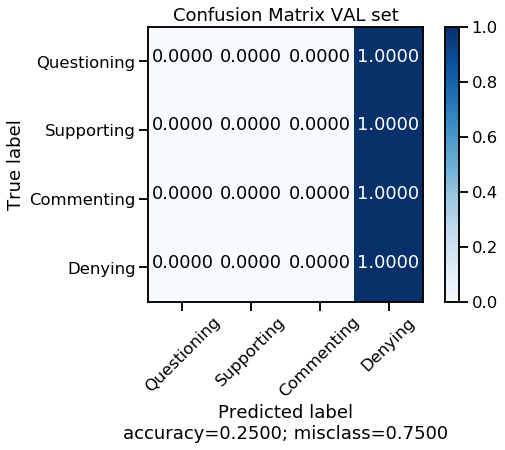

Accuracy TEST: 0.761998041136141
F1-score TEST: 0.2162312395775431
F1-score none average TEST: [0.         0.         0.         0.86492496]


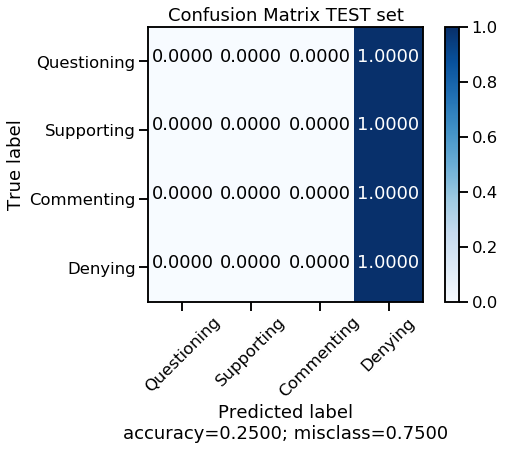


ENTRENANDO MODELO Linear SVM
Accuracy VAL: 0.5444839857651246
F1-score VAL: 0.288972583609878
F1-score none average VAL: [0.35514019 0.05882353 0.05263158 0.68929504]


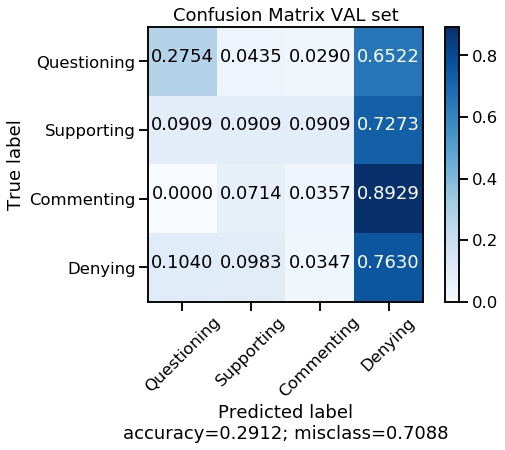

Accuracy TEST: 0.6287952987267384
F1-score TEST: 0.3086804350341317
F1-score none average TEST: [0.08888889 0.1641791  0.2        0.78165375]


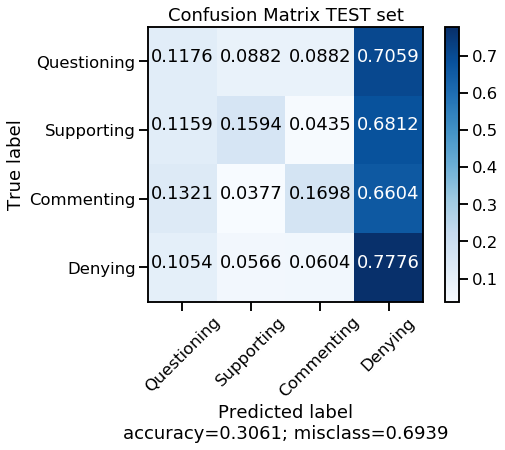


ENTRENANDO MODELO SVM
Accuracy VAL: 0.6192170818505338
F1-score VAL: 0.34740781501898
F1-score none average VAL: [0.49180328 0.10526316 0.06060606 0.73195876]


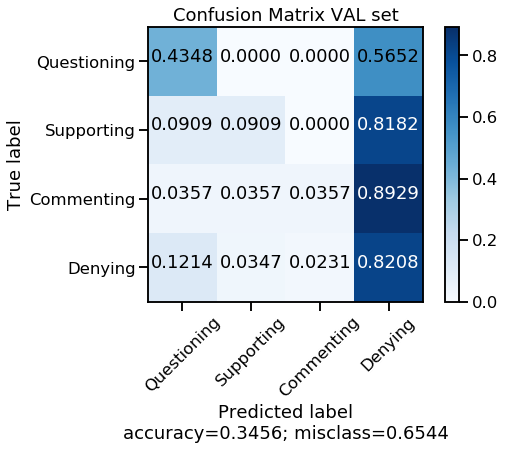

Accuracy TEST: 0.7208619000979432
F1-score TEST: 0.2738191173441519
F1-score none average TEST: [0.10344828 0.06818182 0.08264463 0.84100175]


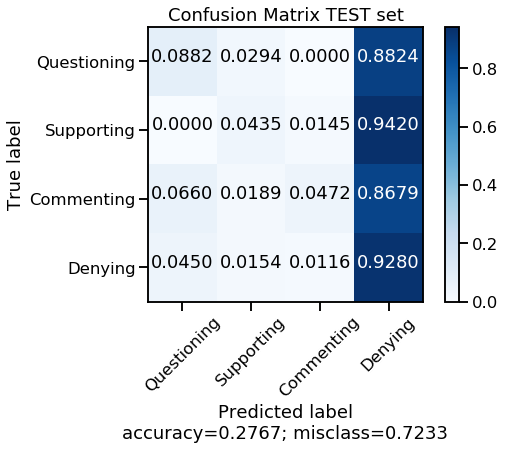

In [63]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(class_weight='balanced'),
    SVC(class_weight='balanced'),
]

modelos={0:'Random Forest', 1: 'Linear SVM', 2:'SVM'}
i=0

for model_to_train in models:
    print ("")
    print ("ENTRENANDO MODELO", modelos[i])
    model=model_to_train
    model.fit(features, labels)
    y_pred_val = model.predict(x_val)
    y_pred_test = model.predict(x_test)
    
    acc= accuracy_score(y_val, y_pred_val)  
    f1_ma=f1_score(y_val, y_pred_val, average='macro')
    f1_no=f1_score(y_val, y_pred_val, average=None)

    print ("Accuracy VAL:",acc)  
    print ("F1-score VAL:",f1_ma)
    print ("F1-score none average VAL:",f1_no)

    matriz=confusion_matrix(y_val, y_pred_val)
    plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix VAL set")
    
    acc= accuracy_score(y_test, y_pred_test)  
    f1_ma=f1_score(y_test, y_pred_test, average='macro')
    f1_no=f1_score(y_test, y_pred_test, average=None)

    print ("Accuracy TEST:",acc)  
    print ("F1-score TEST:",f1_ma)
    print ("F1-score none average TEST:",f1_no)

    matriz=confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST set")
    i+=1

    


# Harassment